## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Get a Census API key and replace it in the cell below

In [4]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API key from the environment variables
api_key = os.getenv("API_KEY")


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [9]:
#%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
#nyc_census_data <- get_acs()

#nyc_census_data


In [29]:
%%R 

# the variable B02018_021 was selected from the census table 
# for Asian Alone or in Any Combination by Selected Groups, which we found in censusreporter here:
# https://censusreporter.org/tables/B02018/


# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
new_jersey_data <- get_acs(geography = "tract", 
                      state='NJ',
                      variables = c(
                        asian_Indian="B02018_021",
                        population="B01003_001"
                      ), 
                      year = 2022,
                      survey="acs5",
                      geometry=T)

new_jersey_data

Simple feature collection with 4362 features and 5 fields (with 12 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -75.55954 ymin: 38.92852 xmax: -73.89363 ymax: 41.35742
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                           NAME     variable
1  34019011400 Census Tract 114; Hunterdon County; New Jersey   population
2  34019011400 Census Tract 114; Hunterdon County; New Jersey asian_Indian
3  34019011900 Census Tract 119; Hunterdon County; New Jersey   population
4  34019011900 Census Tract 119; Hunterdon County; New Jersey asian_Indian
5  34021001800     Census Tract 18; Mercer County; New Jersey   population
6  34021001800     Census Tract 18; Mercer County; New Jersey asian_Indian
7  34021002000     Census Tract 20; Mercer County; New Jersey   population
8  34021002000     Census Tract 20; Mercer County; New Jersey asian_Indian
9  34021003602  Census Tract 36.02; Mercer County; New Jersey   population
10

Getting data from the 2018-2022 5-year ACS
Using FIPS code '34' for state 'NJ'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [30]:
%%R 

new_jersey_data <- new_jersey_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )# pivot from wide to long

new_jersey_data

Simple feature collection with 2181 features and 6 fields (with 6 geometries empty)
Geometry type: MULTIPOLYGON


Dimension:     XY
Bounding box:  xmin: -75.55954 ymin: 38.92852 xmax: -73.89363 ymax: 41.35742
Geodetic CRS:  NAD83
# A tibble: 2,181 × 7
   GEOID       NAME                                 geometry population_estimate
   <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 34019011400 Census Tract 114; … (((-74.8681 40.51168, -7…                4864
 2 34019011900 Census Tract 119; … (((-74.95426 40.37655, -…                4127
 3 34021001800 Census Tract 18; M… (((-74.75495 40.2377, -7…                4579
 4 34021002000 Census Tract 20; M… (((-74.75889 40.22638, -…                1555
 5 34021003602 Census Tract 36.02… (((-74.79389 40.26445, -…                2928
 6 34021002602 Census Tract 26.02… (((-74.72105 40.20524, -…                4688
 7 34021000200 Census Tract 2; Me… (((-74.75286 40.20628, -…                3437
 8 34025809704 Census Tract 8097.… (((-74.29027 40.29362, -…                6302
 9 34025800702 Census Tract 8007.… (((-74.13418 40.4

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [32]:
%%R 

# your code here. refer to example notebooks for help

# Calculate total population
total_population <- sum(new_jersey_data$asian_Indian_estimate, na.rm = TRUE)
print(total_population)

# Calculate population percentage
new_jersey_data <- new_jersey_data %>%
  mutate(population_percentage = (asian_Indian_estimate / total_population) * 100)

new_jersey_data



[1] 432115
Simple feature collection with 2181 features and 7 fields (with 6 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -75.55954 ymin: 38.92852 xmax: -73.89363 ymax: 41.35742
Geodetic CRS:  NAD83
# A tibble: 2,181 × 8
   GEOID       NAME                                 geometry population_estimate
 * <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 34019011400 Census Tract 114; … (((-74.8681 40.51168, -7…                4864
 2 34019011900 Census Tract 119; … (((-74.95426 40.37655, -…                4127
 3 34021001800 Census Tract 18; M… (((-74.75495 40.2377, -7…                4579
 4 34021002000 Census Tract 20; M… (((-74.75889 40.22638, -…                1555
 5 34021003602 Census Tract 36.02… (((-74.79389 40.26445, -…                2928
 6 34021002602 Census Tract 26.02… (((-74.72105 40.20524, -…                4688
 7 34021000200 Census Tract 2; Me… (((-74.75286 40.20628, -…                3437
 8 3402580

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

In addition: Warning message:
In geom_histogram(stat = "identity", fill = "blue", color = "black") :
  Ignoring unknown parameters: `binwidth`, `bins`, and `pad`


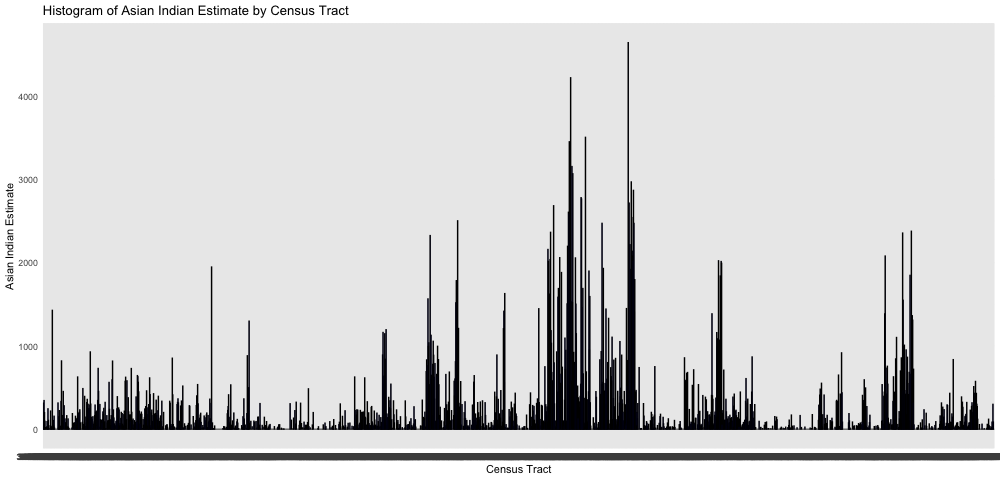

In [36]:
%%R -w 1000

# your code here. refer to example notebooks for help

ggplot(new_jersey_data, aes(x = GEOID, y = asian_Indian_estimate)) +
  geom_histogram(stat = "identity", fill = "blue", color = "black") +
  labs(title = "Histogram of Asian Indian Estimate by Census Tract",
       x = "Census Tract",
       y = "Asian Indian Estimate") +
  theme_minimal()

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

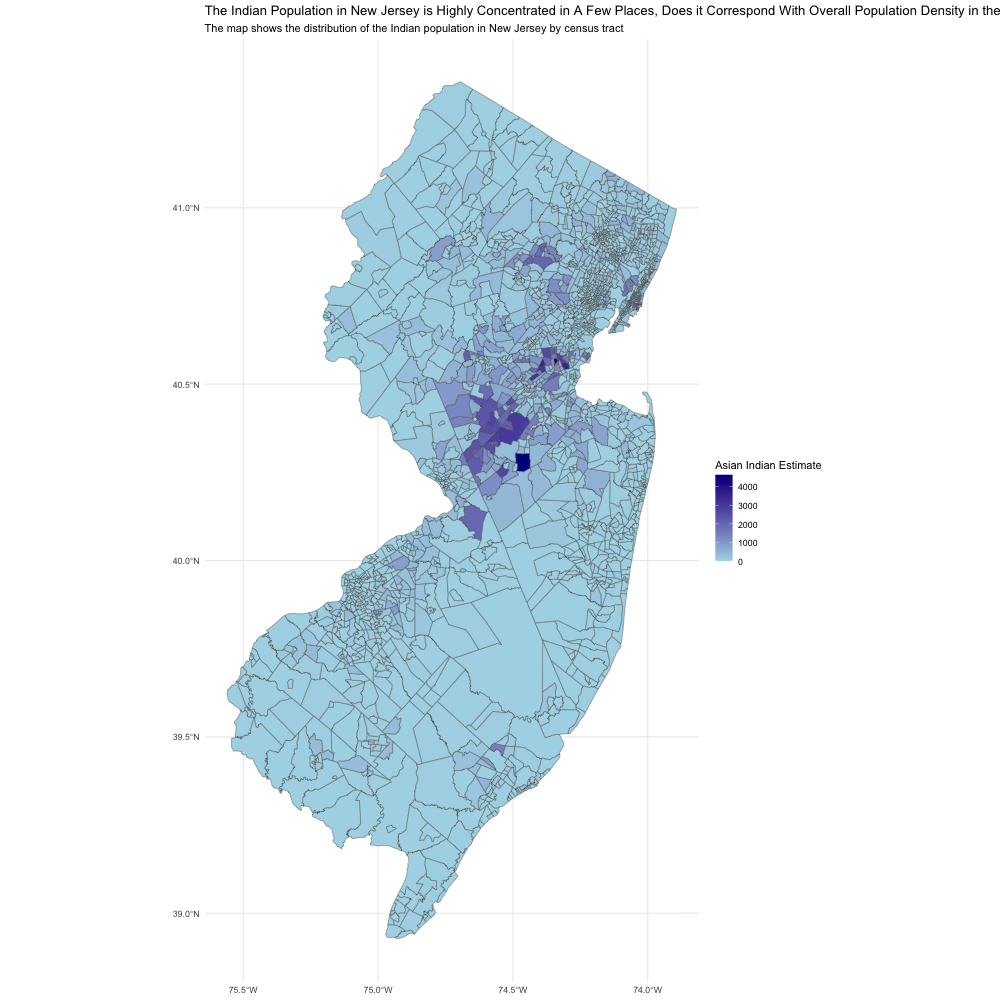

In [39]:
%%R -w 1000 -h 1000

# your code here. refer to example notebooks for help
library(ggplot2)
library(sf)

# Assuming new_jersey_data is already loaded and contains the necessary columns and geometries

# Convert new_jersey_data to sf object
new_jersey_sf <- st_as_sf(new_jersey_data)

# Plot map
ggplot() +
  geom_sf(data = new_jersey_sf, aes(fill = asian_Indian_estimate)) +
  scale_fill_gradient(name = "Asian Indian Estimate", low = "lightblue", high = "darkblue") +
  labs(title = "The Indian Population in New Jersey is Highly Concentrated in A Few Places, Does it Correspond With Overall Population Density in the State?",
  subtitle = "The map shows the distribution of the Indian population in New Jersey by census tract")+
  theme_minimal()